#  Detection of Floating Marine Debris

* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a)
[wofs_ls_summary_alltime](https://explorer.digitalearth.africa/wofs_ls_summary_alltime)

## Background

Marine plastic pollution is a global concern that threatens marine ecosystems and human health. Detecting and quantifying plastic waste in the marine environment is crucial for addressing this problem. Remote sensing techniques, particularly using satellite imagery, have emerged as a promising tool for identifying and monitoring plastic debris in the ocean. In this notebook, we will explore the use of the Floating Debris Index (FDI) and Normalized Difference Vegetation Index (NDVI) for detecting floating plastics in Sentinel-2 satellite imagery. These indices have demonstrated superior performance in detecting floating marine plastics in various locations such as Greece ([Topouzelis et al., 2019](https://doi.org/10.1016/j.jag.2019.03.011), [2020](https://doi.org/10.3390/rs12122013)), Cyprus [(Themistocleous et al., 2020)](https://doi.org/10.3390/RS12162648), and Durban [(Biermann et al., 2020)](https://doi.org/10.1038/s41598-020-62298-z).

**Detecting Marine Debris**: 

Marine Debris pose a significant threat to marine life and human health. Detecting their presence in water bodies has become a global priority. To address this, we will utilize the FDI and NDVI applied to Sentinel-2 satellite imagery.

1. Floating Debris Index (FDI):
The Floating Debris Index (FDI) is a spectral index specifically designed to detect and quantify floating debris on the water surface. By calculating the FDI using Sentinel-2 satellite imagery, we can effectively identify areas where marine debris are present in the study area. The FDI takes advantage of the unique spectral characteristics exhibited by floating debris, allowing us to distinguish them from other features in the image. A thresholding technique will be applied to the FDI values, enabling the separation of marine debris from the surrounding water and other materials.

2. Normalized Difference Vegetation Index (NDVI):
Although primarily designed for vegetation monitoring, the Normalized Difference Vegetation Index (NDVI) can be adapted to detect floating marine debris as well. marine debris often exhibit spectral properties that distinguish them from natural features. By calculating the NDVI using Sentinel-2 imagery, we can leverage these spectral differences to identify potential marine debris locations. The NDVI quantifies the difference between the near-infrared and red spectral bands, providing an indication of the presence of marine debris based on their unique spectral responses. This allows us to distinguish marine debris from other materials in the image, aiding in the detection and characterization of floating plastic debris.

## Description

Notebook Workflow:
The following steps will be covered in this notebook to detect floating marine debris:

1. Data Preprocessing:
   - Obtain Sentinel-2 satellite imagery for the study area.
   - Perform necessary pre-processing steps such as atmospheric correction and radiometric calibration.
2. Calculation of Spectral Indices:
   - Calculate the FDI and NDVI based on the spectral bands of the Sentinel-2 imagery.
3. Thresholding Techniques:
   - Apply thresholding techniques to the FDI and NDVI to separate marine debris from other features in the imagery.
   - Determine suitable threshold values based on previous studies or experimentation.
4. Marine debris Detection and Quantification:
   - Identify and extract potential marine debris locations based on the thresholded indices.
   - Generate statistics and metrics to quantify the extent and distribution of marine debris in the study area.
5. Result Analysis:
   - Analyze the detected marine debris distribution patterns and their potential sources.
   - Compare the results with available ground-truth data to validate the findings.
   
   
For assessing the accuracy of our marine debris detection method, this notebook uses the [Marine Debris Dataset for Object Detection in Planetscope Imagery Dataset](https://mlhub.earth/data/nasa_marine_debris). This dataset comprises 256x256 pixel images extracted from PlanetScope optical imagery, annotated with bounding boxes and geographical coordinates. The dataset covers diverse marine debris types, including plastics, algae, sargassum, wood, and other artifacts. This dataset will serve as ground truth, enabling us to quantitatively measure our detection model's accuracy.

## Import necessary libraries

In [1]:
# Load the necessary python packages.
%matplotlib inline
import os
import datacube
import seaborn as sns
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from datacube.utils.geometry import Geometry
from shapely.geometry import LineString
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from sklearn import preprocessing
from IPython.display import Markdown

from deafrica_tools.spatial import xr_vectorize
from deafrica_tools.plotting import rgb
from deafrica_tools.plotting import display_map
from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.areaofinterest import define_area
from deafrica_tools.bandindices import calculate_indices

## Connect to the datacube

In [2]:
dc = datacube.Datacube(app='detect_marine_debris')

### Analysis parameters

#### Select location
To define the area of interest, there are two methods available:

1. By specifying the latitude, longitude, and buffer. This method requires you to input the central latitude, central longitude, and the buffer value in square degrees around the center point you want to analyze. For example, `lat = 10.338`, `lon = -1.055`, and `buffer = 0.1` will select an area with a radius of 0.1 square degrees around the point with coordinates (10.338, -1.055).

    Alternatively, you can provide separate buffer values for latitude and longitude for a rectangular area. For example, `lat = 10.338`, `lon = -1.055`, and `lat_buffer = 0.1` and`lon_buffer = 0.08` will select a rectangular area extending 0.1 degrees north and south, and 0.08 degrees east and west from the point `(10.338, -1.055)`.

   For reasonable loading times, set the buffer as `0.1` or lower.

2. By uploading a polygon as a `GeoJSON or Esri Shapefile`. If you choose this option, you will need to upload the geojson or ESRI shapefile into the Sandbox using Upload Files button <img align="top" src="../Supplementary_data/upload_files_icon.png"> in the top left corner of the Jupyter Notebook interface. ESRI shapefiles must be uploaded with all the related files `(.cpg, .dbf, .shp, .shx)`. Once uploaded, you can use the shapefile or geojson to define the area of interest. Remember to update the code to call the file you have uploaded.

To use one of these methods, you can uncomment the relevant line of code and comment out the other one. To comment out a line, add the `"#"` symbol before the code you want to comment out. By default, the first option which defines the location using latitude, longitude, and buffer is being used.

In [3]:
# Method 1: Specify the latitude, longitude, and buffer
# aoi = define_area(lat=10.338, lon=-1.055, buffer=0.1)

# Method 2: Use a polygon as a GeoJSON or Esri Shapefile.
aoi = define_area(
    vector_path=
    f"../Supplementary_data/Floating_marine_debris/nasa_marine_debris_labels_ghana_bounding_box.geojson"
)

#Create a geopolygon and geodataframe of the area of interest
geopolygon = Geometry(aoi["features"][0]["geometry"], crs="epsg:4326")
geopolygon_gdf = gpd.GeoDataFrame(geometry=[geopolygon], crs=geopolygon.crs)

# Get the latitude and longitude range of the geopolygon
lat_range = (geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[3])
lon_range = (geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[2])

In [4]:
display_map(x=lon_range, y=lat_range)

## Load the Sentinel-2 data for the area of interest and time range
**Note**:  In this notebook, the presented example focuses on a single timestamp, specifically '2018-10-31,' for which we have access to ground truth data in the form of the [Marine Debris Dataset for Object Detection in Planetscope Imagery Dataset](https://mlhub.earth/data/nasa_marine_debris) within the designated area of interest. However, the workflow's flexibility allows for seamless adaptation to analye data over a range of timestamps. This capability enables you to examine the presence and distribution of debris across different points in time within the specified date range. Whether you're interested in a specific time period or conducting comparative analyses across multiple timestamps, the workflow can be customized to suit your research needs.

In [5]:
product = 's2_l2a'
query = {
    'geopolygon': geopolygon,
    'time': ('2018-10-31'),
    'output_crs': 'EPSG:6933',
    'resolution': (-10, 10),
    'measurements': ['blue', 'green', 'red', 'red_edge_2', 'nir', 'swir_1'],
    'group_by': "solar_day",
}

ds = dc.load(product=product, **query)
ds

<xarray.Dataset> Size: 30MB
Dimensions:      (time: 1, y: 1633, x: 1538)
Coordinates:
  * time         (time) datetime64[ns] 8B 2018-10-31T10:19:11
  * y            (y) float64 13kB 7.068e+05 7.068e+05 ... 6.905e+05 6.905e+05
  * x            (x) float64 12kB -3.416e+04 -3.416e+04 ... -1.88e+04 -1.88e+04
    spatial_ref  int32 4B 6933
Data variables:
    blue         (time, y, x) uint16 5MB 852 1020 1320 1630 ... 440 424 411 402
    green        (time, y, x) uint16 5MB 1180 1510 1864 2096 ... 319 294 301 312
    red          (time, y, x) uint16 5MB 1430 2192 2200 2498 ... 214 211 220 218
    red_edge_2   (time, y, x) uint16 5MB 2978 2653 2653 2750 ... 203 209 209 199
    nir          (time, y, x) uint16 5MB 3194 3164 2832 2812 ... 198 189 180 197
    swir_1       (time, y, x) uint16 5MB 3112 3588 3588 3547 ... 168 172 172 160
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

### Normalise the intensity of the bands
Normalizing the intensity of the bands used in the Floating Debris Index (FDI) is important to ensure that the FDI is not biased by differences in brightness or reflectance values across the image. Normalization helps to standardize the range of values across the bands, so that each band contributes equally to the index regardless of its original intensity values.

If the intensity values of the bands are not normalized, it can lead to inaccuracies in the FDI results, such as false positives or false negatives. For example, if one band has significantly higher intensity values than the others, it may dominate the FDI calculation and lead to an overestimation of the amount of floating debris present in the image.

By normalizing the intensity values, the FDI is calculated based on the relative differences in reflectance values between the two bands, rather than the absolute intensity values. This helps to ensure that the FDI is a more accurate indicator of the presence of floating debris, and reduces the impact of other factors that may affect the brightness or reflectance values of the image, such as cloud cover or varying illumination conditions.

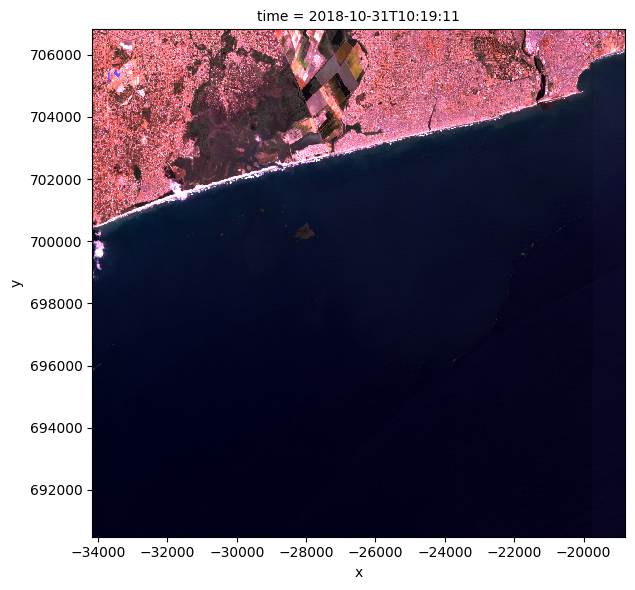

In [6]:
# Function to normalize the band values using scikit-learn.
def normalize_bands(ds):
    bands = list(ds.data_vars)
    for band in bands:
        # Get the band's data as a 2D array (time x pixel).
        band_data = ds[band].values.reshape(-1, 1)

        # Initialize the MinMaxScaler.
        scaler = preprocessing.MinMaxScaler()

        # Fit the scaler on the data and transform it to normalize the values.
        normalized_data = scaler.fit_transform(band_data)

        # Update the dataset with the normalized values.
        ds[band] = xr.DataArray(normalized_data.reshape(ds[band].shape),
                                dims=ds[band].dims)

    return ds


# Normalize the bands.
normalized_ds = normalize_bands(ds)
rgb(normalized_ds, col="time")

## Mask non-marine areas
#### Load World bank coastlines
World Bank-approved coastlines downloaded from https://datacatalog.worldbank.org/search/dataset/0038272

In [7]:
world_coastlines = gpd.read_file(
    "../Supplementary_data/Floating_marine_debris/WB_Coastlines_10m.shp")

#Clip the coastline to the area of interest
coastline = gpd.clip(world_coastlines, geopolygon_gdf)
coastline.explore(column='featurecla', cmap='inferno', categorical=True)

#### Buffer the coastline and mask out areas inland of the coastline

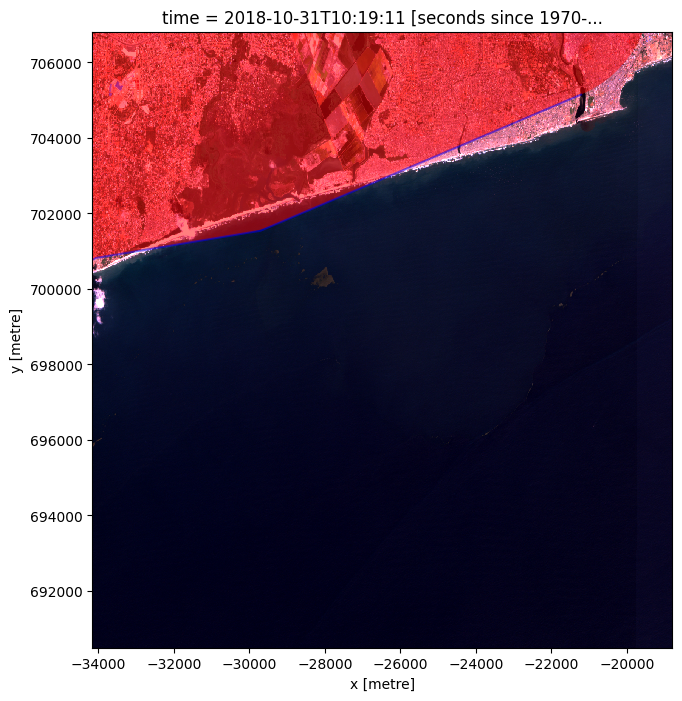

In [8]:
# Check the CRS and reproject if necessary
if coastline.crs != 'epsg:6933':
    coastline = coastline.to_crs('epsg:6933')

# Assuming you have a GeoDataFrame called 'coastline' with a LineString geometry column
side = "left"  # Choose the side of the line for buffering ("right" or "left")
buffer_distance = 3000  # Specify the buffer distance in the appropriate units

# Convert LineString to a list of LineString geometries
line_geometries = list(coastline.geometry)

# Create a buffered line on the desired side
buffered_geometries = []
for line in line_geometries:
    if side == "right":
        offset_line = line.parallel_offset(buffer_distance, "right")
    elif side == "left":
        offset_line = line.parallel_offset(buffer_distance, "left")
    buffer = offset_line.buffer(buffer_distance)
    buffer_on_side = buffer.difference(line)
    buffered_geometries.append(buffer_on_side)

# Create a new GeoDataFrame with the buffered geometries
coastline_buffer = gpd.GeoDataFrame(geometry=buffered_geometries,
                                    crs=coastline.crs)

# Plot the buffer on the image to see which parts of the image will be masked.
# This can help with determining if the buffer size is sufficient and removes inland pixels

# Create a figure and axis with a larger figsize
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the rgb
rgb(normalized_ds.isel(time=0), ax=ax)

# Plot the coastline buffer over the dataset
coastline_buffer.plot(ax=ax, color='red', alpha=0.5)

# Plot the coastline over the coastline buffer
coastline.plot(ax=ax, color='blue', alpha=0.5)

# Set the aspect ratio of the plot
ax.set_aspect('equal')

# Set the plot limits to match the extent of the normalized_ds data
ax.set_xlim(normalized_ds.x.min(), normalized_ds.x.max())
ax.set_ylim(normalized_ds.y.min(), normalized_ds.y.max())

# Show the plot
plt.show()

#### Apply the buffer to mask pixels inland of the coastline.

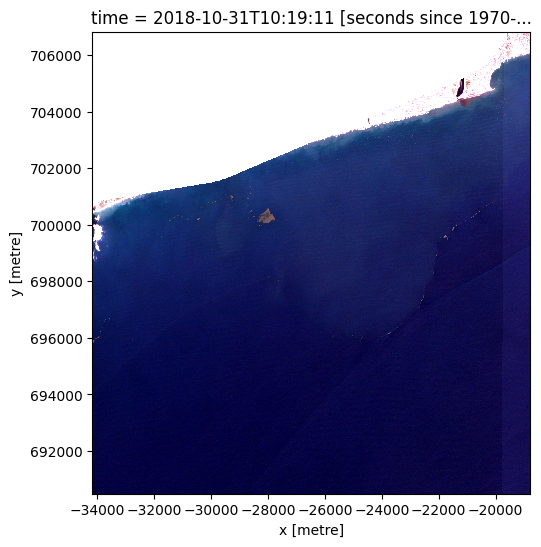

In [9]:
coastline_raster = xr_rasterize(gdf=coastline_buffer,
                                da=ds,
                                crs=ds.crs)

ds_masked_coastline = normalized_ds.where(coastline_raster == 0)
rgb(ds_masked_coastline.isel(time=0))

### Removing additional land areas using the WOfS 'all-time' Summary
The World Bank coastlines dataset is used to mask out land areas. However, due to the dataset's global nature, inaccuracies can occur where coastlines extend into the ocean or further inland. To address this, the Water Observation from Space (WOfS) 'all-time' summary layer is employed to remove erroneously included land areas within the region of interest. Unfortunately, there are no provisions to re-include accidentally excluded water or marine areas in the current notebook.

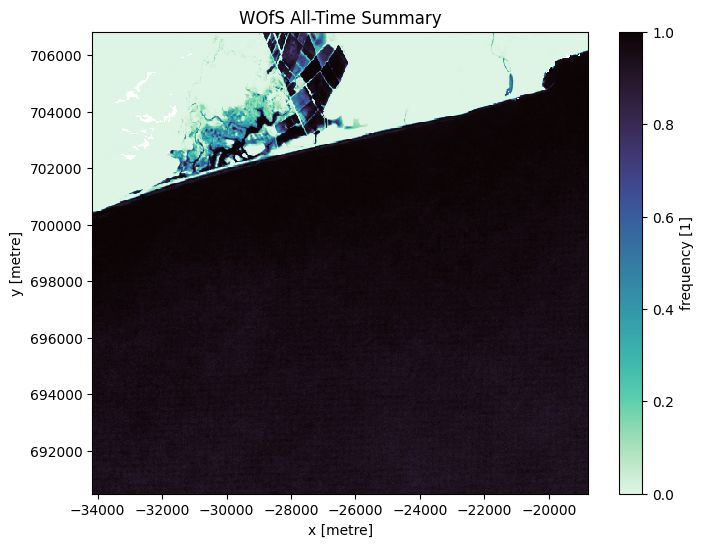

In [10]:
wofs_alltime = dc.load(product='wofs_ls_summary_alltime',
                       geopolygon=geopolygon,
                       resolution=(-30, 30))

wofs_alltime.frequency.plot(size=6,
                            cmap=sns.color_palette("mako_r", as_cmap=True))
plt.title('WOfS All-Time Summary');

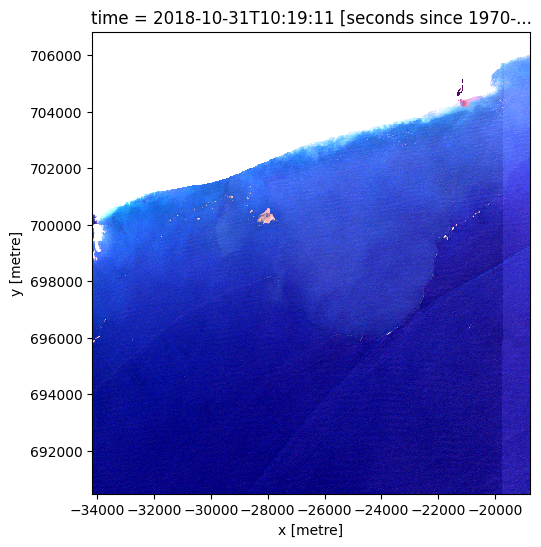

In [11]:
wofs_alltime_wet = wofs_alltime.where(wofs_alltime.frequency >= 0.5)
wofs_alltime_wet = wofs_alltime_wet.isel(time=0)

ds_masked_coastline = ds_masked_coastline.where(
    wofs_alltime_wet.frequency >= 0.5)
rgb(ds_masked_coastline.isel(time=0))

## Calculate and plot the Floating Debris Index (FDI) and the Normalized Difference Vegetation Index (NDVI)
1. Floating Debris Index (FDI):
The Floating Debris Index (FDI) is a spectral index specifically designed to detect and quantify floating debris on the water surface. By calculating the FDI using Sentinel-2 satellite imagery, we can effectively identify areas where marine debris are present in the study area. The FDI takes advantage of the unique spectral characteristics exhibited by floating debris, allowing us to distinguish them from other features in the image. A thresholding technique will be applied to the FDI values, enabling the separation of marine debris from the surrounding water and other materials.

   ### Floating Debris Index (FDI) 

   \begin{equation}
   \text{FDI} = R_{rs},NIR - (R_{rs},RE2 + (R_{rs}, SWIR1 - R_{rs}, RE2) * \frac{(\lambda_{NIR} - \lambda_{RED})}{(\lambda_{SWIR1} - \lambda_{RED})} * 10)
   \end{equation}


   where $R_{rs,NIR}$, $R_{rs, RE2}$, $R_{rs, SWIR1}$ are the reflectance values in the near infrared, red edge 2, and
   short-wave infrared bands, respectively, $λ_i$ are the wavelength with subscript band name. 


   >Note wavelength values are the central wavelengths from https://www.usgs.gov/centers/eros/science/usgs-eros-archive-sentinel-2

2. Normalized Difference Vegetation Index (NDVI):
Although primarily designed for vegetation monitoring, the Normalized Difference Vegetation Index (NDVI) can be adapted to detect floating marine debris as well. Marine debris often exhibit spectral properties that distinguish them from natural features. By calculating the NDVI using Sentinel-2 imagery, we can leverage these spectral differences to identify potential marine debris locations. The NDVI quantifies the difference between the near-infrared and red spectral bands, providing an indication of the presence of marine debris based on their unique spectral responses. This allows us to distinguish marine debris from other materials in the image, aiding in the detection and characterization of floating plastic debris.

   ### Normalized Difference Vegetation Index (NDVI) 

   \begin{equation}
   \text{NDVI} =  \frac{R_{rs},NIR - R_{rs},RED}{R_{rs},NIR + R_{rs},RED}
   \end{equation}


   where $R_{rs,NIR}$, $R_{rs, RED}$ are the reflectance values in the near infrared, and red bands, respectively. 
   
   


In [12]:
wavelength_nir = 842 * 1e-9
wavelength_red = 665 * 1e-9
wavelength_swir1 = 1610 * 1e-9

ds_masked_coastline["FDI"] = ds_masked_coastline.nir - (
    ds_masked_coastline.red_edge_2 +
    (ds_masked_coastline.swir_1 - ds_masked_coastline.red_edge_2) *
    ((wavelength_nir - wavelength_red) /
     (wavelength_swir1 - wavelength_red)) * 10)
ds_masked_coastline = calculate_indices(ds_masked_coastline,
                                        index=['NDVI'],
                                        satellite_mission='s2')

ds_masked_coastline

<xarray.Dataset> Size: 18MB
Dimensions:      (time: 1, y: 545, x: 513)
Coordinates:
  * time         (time) datetime64[ns] 8B 2018-10-31T10:19:11
  * y            (y) float64 4kB 7.068e+05 7.068e+05 ... 6.905e+05 6.905e+05
  * x            (x) float64 4kB -3.416e+04 -3.412e+04 ... -1.882e+04 -1.88e+04
    spatial_ref  int32 4B 6933
Data variables:
    blue         (time, y, x) float64 2MB nan nan nan ... 0.02373 0.02076
    green        (time, y, x) float64 2MB nan nan nan ... 0.006422 0.006031
    red          (time, y, x) float64 2MB nan nan nan ... 0.00716 0.007497
    red_edge_2   (time, y, x) float64 2MB nan nan nan ... 0.01732 0.01671
    nir          (time, y, x) float64 2MB nan nan nan ... 0.006143 0.006076
    swir_1       (time, y, x) float64 2MB nan nan nan ... 0.007571 0.006508
    FDI          (time, y, x) float64 2MB nan nan nan ... 0.007084 0.008472
    NDVI         (time, y, x) float64 2MB nan nan nan ... -0.07645 -0.1047
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

This code defines the affine and CRS (Coordinate Reference System) variables of the dataset ds_masked_coastline, which are required for plotting the data. It then creates a new dataset ds_fdi which contains the FDI values obtained from the previous step. 

The output plot can be used to visualize the distribution of floating debris in water bodies over time. 

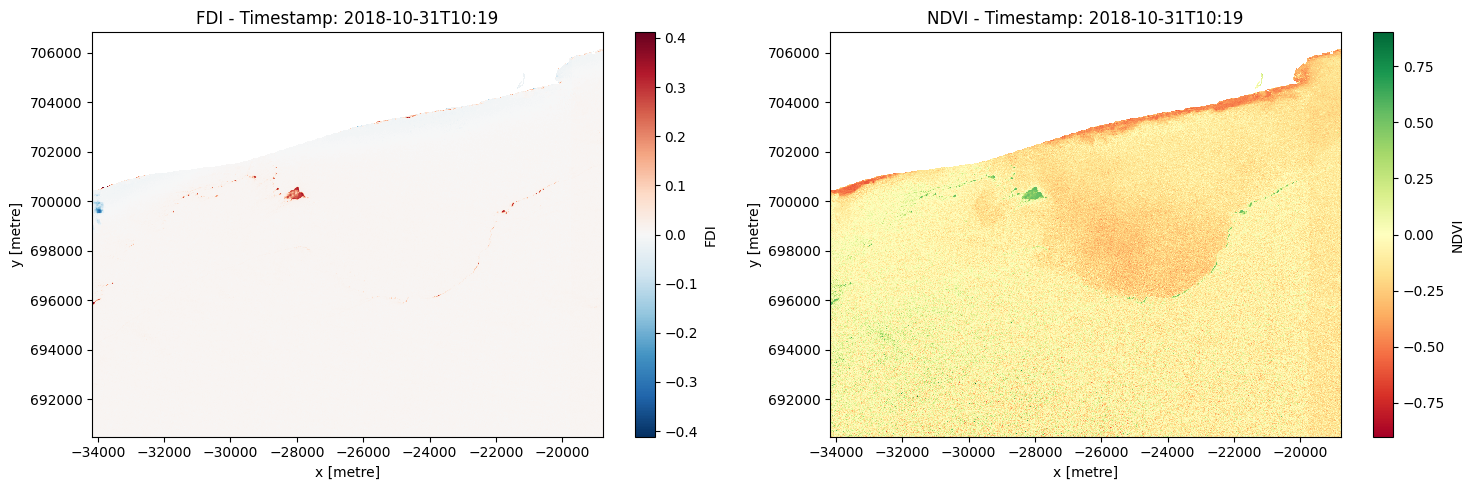

In [13]:
ds_fdi = ds_masked_coastline["FDI"].squeeze()
ds_ndvi = ds_masked_coastline["NDVI"].squeeze()

# Calculate the number of rows and columns needed
try:
    num_plots = ds_fdi.sizes['time']
except KeyError:
    num_plots = 1  # if only one timestamp
num_cols = 2
num_rows = num_plots

# Create the figure and subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Loop over each timestamp and plot the corresponding FDI and NDVI images
for i in range(num_plots):
    time_val = str(ds_masked_coastline["FDI"].time.values[i]
                  )[:-13]  # Extract timestamp and convert to string

    # Plot FDI
    if num_plots == 1:
        ds_fdi.plot(ax=axs[0], cmap='RdBu_r')
        axs[0].set_title(f'FDI - Timestamp: {time_val}')
    else:
        ds_fdi.isel(time=i).plot(ax=axs[i, 0], cmap='RdBu_r')
        axs[i, 0].set_title(f'FDI - Timestamp: {time_val}')

    # Plot NDVI
    if num_plots == 1:
        ds_ndvi.plot(ax=axs[1], cmap='RdYlGn')
        axs[1].set_title(f'NDVI - Timestamp: {time_val}')
    else:
        ds_ndvi.isel(time=i).plot(ax=axs[i, 1], cmap='RdYlGn')
        axs[i, 1].set_title(f'NDVI - Timestamp: {time_val}')

# Remove any unused subplots
for i in range(num_plots, num_rows):
    fig.delaxes(axs[i, 0])
    fig.delaxes(axs[i, 1])

plt.tight_layout()
plt.show()

## Select and apply threshold
The best threshold for identifying debris from the FDI will depend on the characteristics of your data and the specific application you are working on.

One way to determine the best threshold is to create a histogram of the FDI values and visually inspect it to identify a threshold value that separates the distribution into two distinct groups, one representing marine debris and the other representing non-marine debris.

### Threshold for each timestamp and plot histograms
The 3-sigma rule is a statistical method used to determine if a data point is an outlier, which means it is significantly different from the other data points. In this case, we used it to identify pixels in the satellite imagery that were likely to be marine debris.

To do this, we first calculated the mean and standard deviation of values for all pixels in the satellite imagery. We then set a threshold at 3 standard deviations above the mean, which means any pixel with a value above this threshold was classified as a marine debris.

Plot histograms of the FDI and NDVI values for each timestamp, with the threshold value plotted as a vertical red dashed line. This is a good way to visualize the distribution of the FDI and NDVI values and how the threshold value relates to the data.

Threshold per timestamp (FDI): [0.040867291239177636]
Threshold per timestamp (NDVI): [0.27210095592438976]


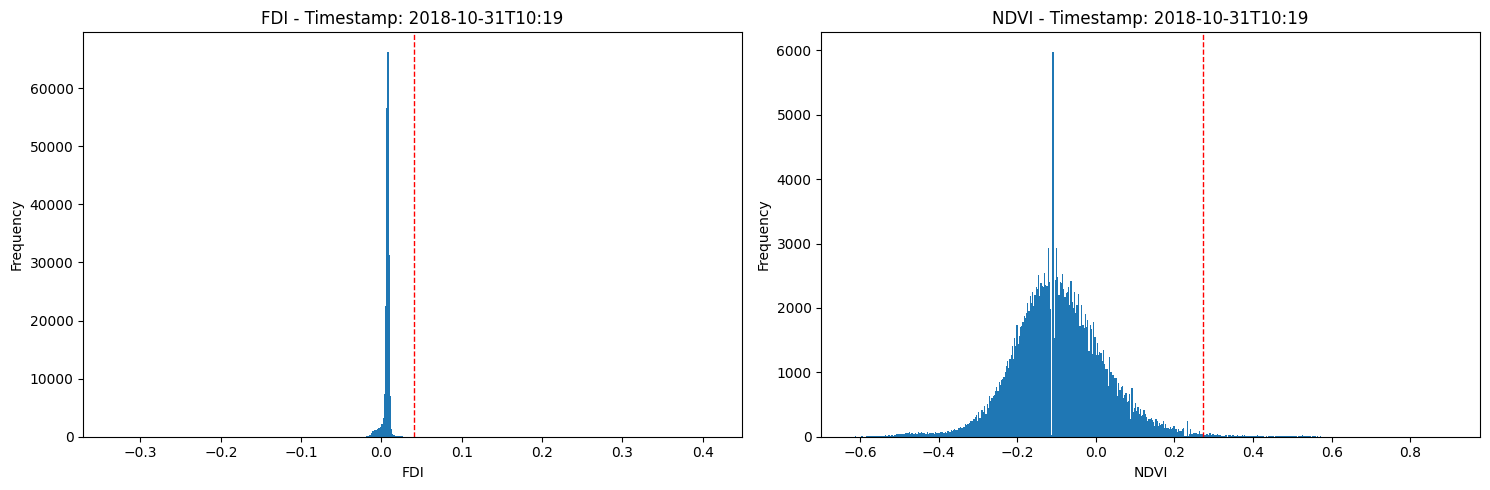

In [14]:
fdi_values = ds_fdi.values
ndvi_values = ds_ndvi.values

# Calculate thresholds for each timestamp
threshold_per_timestamp_fdi = []
threshold_per_timestamp_ndvi = []

if len(fdi_values.shape) == 2:
    # Only one timestamp
    fdi_values = fdi_values[None, :]  # Add time dimension
    ndvi_values = ndvi_values[None, :]  # Add time dimension

    # FDI threshold calculation
    fdi_values_i = fdi_values[0, :]
    fdi_values_i = fdi_values_i[~np.isnan(fdi_values_i)]
    threshold_i_fdi = np.mean(fdi_values_i) + (3 * np.std(fdi_values_i))
    threshold_per_timestamp_fdi.append(threshold_i_fdi)

    # NDVI threshold calculation
    ndvi_values_i = ndvi_values[0, :]
    ndvi_values_i = ndvi_values_i[~np.isnan(ndvi_values_i)]
    threshold_i_ndvi = np.mean(ndvi_values_i) + (3 * np.std(ndvi_values_i))
    threshold_per_timestamp_ndvi.append(threshold_i_ndvi)
else:
    # Multiple timestamps
    for i in range(fdi_values.shape[0]):
        # Remove missing values for this timestamp
        fdi_values_i = fdi_values[i, :]
        ndvi_values_i = ndvi_values[i, :]
        fdi_values_i = fdi_values_i[~np.isnan(fdi_values_i)]
        ndvi_values_i = ndvi_values_i[~np.isnan(ndvi_values_i)]

        # FDI threshold calculation
        threshold_i_fdi = np.mean(fdi_values_i) + (3 * np.std(fdi_values_i))
        threshold_per_timestamp_fdi.append(threshold_i_fdi)

        # NDVI threshold calculation
        threshold_i_ndvi = np.mean(ndvi_values_i) + (3 * np.std(ndvi_values_i))
        threshold_per_timestamp_ndvi.append(threshold_i_ndvi)

# Print the calculated thresholds for FDI and NDVI
print("Threshold per timestamp (FDI):", threshold_per_timestamp_fdi)
print("Threshold per timestamp (NDVI):", threshold_per_timestamp_ndvi)

# Create the figure and subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Loop over each timestamp and plot the corresponding histograms for FDI and NDVI
for i in range(num_plots):
    time_val = str(ds_masked_coastline["FDI"].time.values[i]
                  )[:-13]  # Extract timestamp and convert to string

    # FDI histogram
    if num_plots == 1:
        axs[0].hist(fdi_values.flatten(), bins=500)
        axs[0].axvline(threshold_per_timestamp_fdi[i],
                       color='r',
                       linestyle='dashed',
                       linewidth=1)
        axs[0].set_xlabel('FDI')
        axs[0].set_ylabel('Frequency')
        axs[0].set_title(f'FDI - Timestamp: {time_val}')
    else:
        axs[i, 0].hist(fdi_values[i].flatten(), bins=500)
        axs[i, 0].axvline(threshold_per_timestamp_fdi[i],
                          color='r',
                          linestyle='dashed',
                          linewidth=1)
        axs[i, 0].set_xlabel('FDI')
        axs[i, 0].set_ylabel('Frequency')
        axs[i, 0].set_title(f'FDI - Timestamp: {time_val}')

    # NDVI histogram
    if num_plots == 1:
        axs[1].hist(ndvi_values.flatten(), bins=500)
        axs[1].axvline(threshold_per_timestamp_ndvi[i],
                       color='r',
                       linestyle='dashed',
                       linewidth=1)
        axs[1].set_xlabel('NDVI')
        axs[1].set_ylabel('Frequency')
        axs[1].set_title(f'NDVI - Timestamp: {time_val}')
    else:
        axs[i, 1].hist(ndvi_values[i].flatten(), bins=500)
        axs[i, 1].axvline(threshold_per_timestamp_ndvi[i],
                          color='r',
                          linestyle='dashed',
                          linewidth=1)
        axs[i, 1].set_xlabel('NDVI')
        axs[i, 1].set_ylabel('Frequency')
        axs[i, 1].set_title(f'NDVI - Timestamp: {time_val}')

# Remove any unused subplots
for i in range(num_plots, num_rows):
    fig.delaxes(axs[i, 0])
    fig.delaxes(axs[i, 1])

plt.tight_layout()
plt.show()

#### Create and plot FDI and NDVI binary masks
This code creates a series of binary masks for a dataset of satellite imagery at different time steps. The masks are created based on a threshold value calculated for each time step, and the resulting areas of the masks that correspond to marine debris pollution are calculated and stored in a list. The number of marine debris within the area of interest for each time step is also calculated and stored in a separate list. The masks are then plotted as subplots in a grid format with custom colors. The code also removes any unused subplots and adjusts the spacing between subplots. The final output is a figure showing the masks for each time step and the corresponding marine debris area and number of marine debris.

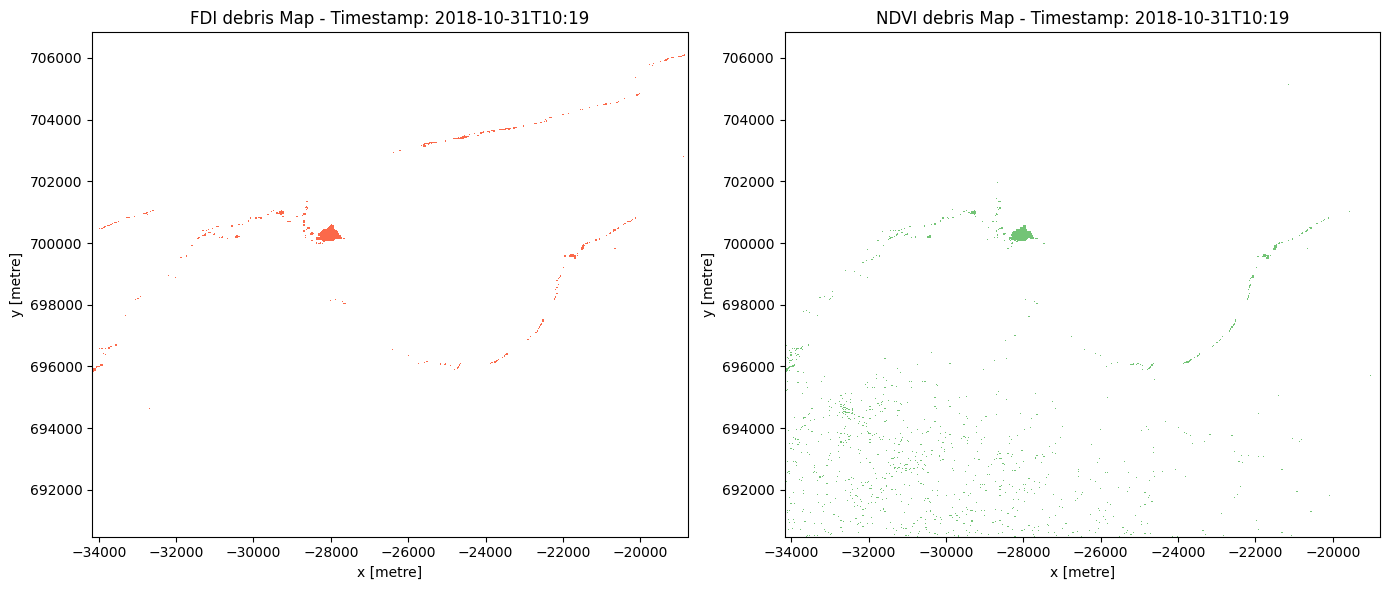

In [15]:
# Create binary maps based on thresholds
binary_fdi = ds_fdi > threshold_per_timestamp_fdi[0]
binary_ndvi = ds_ndvi > threshold_per_timestamp_ndvi[0]

# Create the figure and subplots
fig, axs = plt.subplots(nrows=num_plots, ncols=2, figsize=(14, 6 * num_plots))

# Loop over each timestamp and plot the corresponding debris maps
for i in range(num_plots):
    time_val = str(ds_masked_coastline["FDI"].time.values[i]
                  )[:-13]  # Extract timestamp and convert to string

    # FDI debris map
    if num_plots == 1:
        debris_map_fdi = binary_fdi == 1
        debris_map_fdi = debris_map_fdi.where(
            debris_map_fdi, np.nan)
        plot_fdi = debris_map_fdi.plot(ax=axs[0], cmap='Reds')
        axs[0].set_title(f'FDI debris Map - Timestamp: {time_val}')
    else:
        debris_map_fdi = binary_fdi.isel(time=i) == 1
        debris_map_fdi = debris_map_fdi.where(
            debris_map_fdi, np.nan)
        plot_fdi = debris_map_fdi.plot(ax=axs[i, 0], cmap='Reds')
        axs[i, 0].set_title(f'FDI debris Map - Timestamp: {time_val}')

    # NDVI debris map
    if num_plots == 1:
        debris_map_ndvi = binary_ndvi == 1
        debris_map_ndvi = debris_map_ndvi.where(
            debris_map_ndvi, np.nan)
        plot_ndvi = debris_map_ndvi.plot(ax=axs[1], cmap='Greens')
        axs[1].set_title(f'NDVI debris Map - Timestamp: {time_val}')
    else:
        debris_map_ndvi = binary_ndvi.isel(time=i) == 1
        debris_map_ndvi = debris_map_ndvi.where(
            debris_map_ndvi, np.nan)
        plot_ndvi = debris_map_ndvi.plot(ax=axs[i, 1], cmap='Greens')
        axs[i, 1].set_title(f'NDVI debris Map - Timestamp: {time_val}')

    # Hide color bar
    plot_fdi.colorbar.remove()
    plot_ndvi.colorbar.remove()

# Remove any unused subplots
for i in range(num_plots, num_rows):
    fig.delaxes(axs[i, 0])
    fig.delaxes(axs[i, 1])

plt.tight_layout()
plt.show()

#### Create a single binary map of pixels that are classified as debris using both FDI and NDVI.

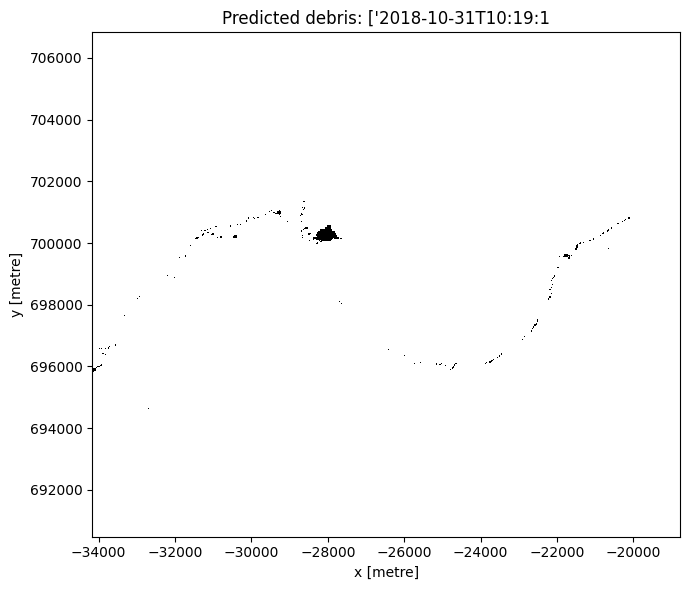

In [16]:
# Determine the number of plots
num_plots = 1 if 'time' not in ds_fdi.dims else ds_fdi.sizes['time']

# Create the figure and subplots
fig, axs = plt.subplots(nrows=num_plots,
                        ncols=1,
                        figsize=(7, 6 * num_plots),
                        squeeze=False)

# Create an array to store the debris masks
debris_masks = []

# Loop over each timestamp and plot the debris map
for i in range(num_plots):
    if num_plots > 1:
        time_val = str(ds_masked_coastline["FDI"].time.values[i]
                      )[:-13]  # Extract timestamp and convert to string
        ax = axs[i, 0]
        debris_map = binary_fdi.isel(time=i) & binary_ndvi.isel(time=i)
    else:
        time_val = str(ds_masked_coastline["FDI"].time.values
                      )[:-13]  # Extract timestamp and convert to string
        ax = axs[0, 0]
        debris_map = binary_fdi & binary_ndvi

    # Store the debris map in the array
    debris_masks.append(debris_map)

    # Plot the debris map with custom colormap
    debris_map.where(debris_map == 1).plot(ax=ax,
                                                         cmap='binary',
                                                         vmin=0,
                                                         vmax=1)
    ax.set_title(f'Predicted debris: {time_val}')

    # Remove the colorbar
    ax.collections[0].colorbar.remove()

plt.tight_layout()
plt.show()

#### Vectorise the identified marine debris pixels for a timestamp of choice

In [17]:
debris_gdf = xr_vectorize(debris_masks[0],
                                 crs=ds_masked_coastline.crs,
                                 mask=debris_masks[0] == 1)

debris_gdf.explore()

## Accuracy assessment
***This notebook uses the NASA Marine Debris Dataset for Object Detection in Planetscope Imagery dataset as validation data for the area of interest (timestamp: (2018-10-31)).*** The dataset, provided in geojson format, is sourced from the [Supplementary_data](../Supplementary_data/Floating_marine_debris/nasa_marine_debris_labels_ghana.geojson) folder. It encompasses annotated vector data, including bounding boxes and geographical coordinates, serving as ground truth for marine debris object detection.

In the accuracy assessment, it is essential to acknowledge that the floating marine debris observed in the Sentinel image used may have moved between its acquisition time and the acquisition of the PlanetScope imagery used to create the NASA Marine Debris Dataset for Object Detection in Planetscope Imagery dataset. Due to the temporal gap and the dynamic nature of floating objects, it is challenging to determine the exact positions of the debris at the time of both image acquisitions. To account for this uncertainty, a buffer has been introduced around the validation dataset, allowing for potential movement of the debris during the time lapse between the two datasets. This approach acknowledges the possibility of displacement and provides a more comprehensive assessment of accuracy by considering the potential shifts in the positions of the floating marine debris.

#### Load and plot the validation data

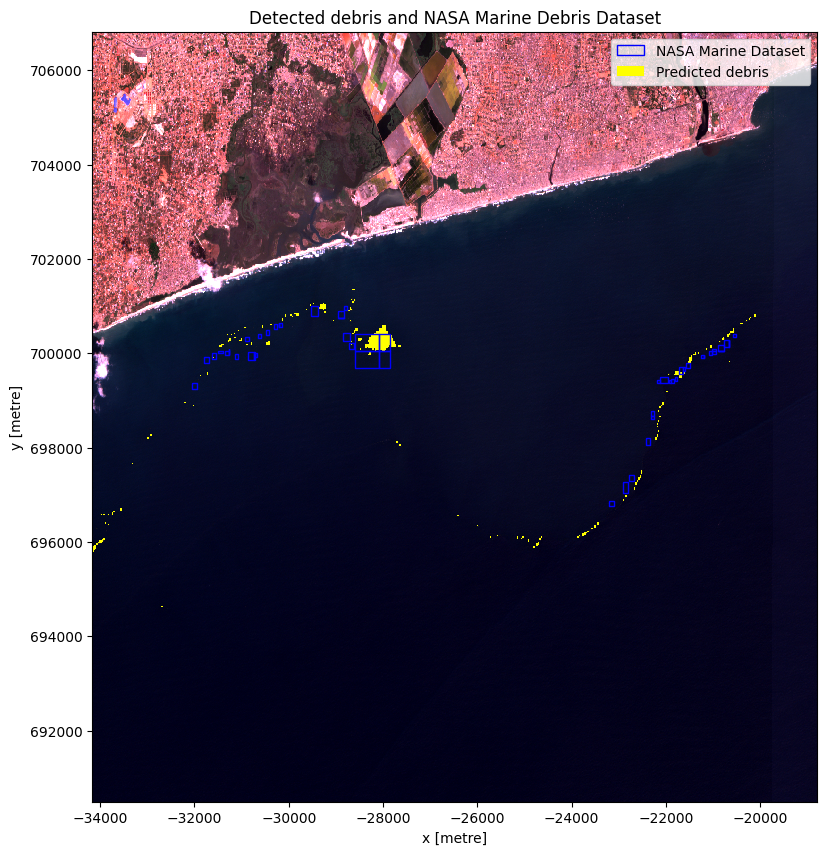

In [18]:
# Load the NASA Marine Debris Dataset for Object Detection in Planetscope Imagery dataset
marine_debris_dataset = gpd.read_file(
    f"../Supplementary_data/Floating_marine_debris/nasa_marine_debris_labels_ghana.geojson"
)
marine_debris_dataset = marine_debris_dataset.to_crs('epsg:6933')

fig, ax = plt.subplots(figsize=(15, 10))
# Plot the identified debris
debris_gdf.plot(ax=ax, facecolor='yellow')
# Plot marine_debris_dataset on the second axis
rgb(ds.isel(time=0), ax=ax)
marine_debris_dataset.plot(ax=ax, facecolor='none', edgecolor='blue')
ax.set_title('Detected debris and NASA Marine Debris Dataset')

# Create custom legend handles and labels
legend_handles = [
    mpatches.Patch(facecolor='none',
                   edgecolor='blue',
                   label='NASA Marine Dataset'),
    mpatches.Patch(facecolor='yellow', label='Predicted debris'),
]
ax.legend(handles=legend_handles)
plt.show()

> The plot above illustrates that the predicted marine debris and the validation data are not perfectly aligned, which is expected due to the movement of floating marine objects. To account for this, introducing buffers around the validation data is necessary, considering the potential movement of marine debris between the time of the Sentinel image capture and the Planetscope Imagery used for validation. These buffers allow for a more robust analysis, accommodating the dynamic behavior of marine debris and enabling a comprehensive examination of potential marine debris locations.

#### Buffer the validation data and assess the accuracy

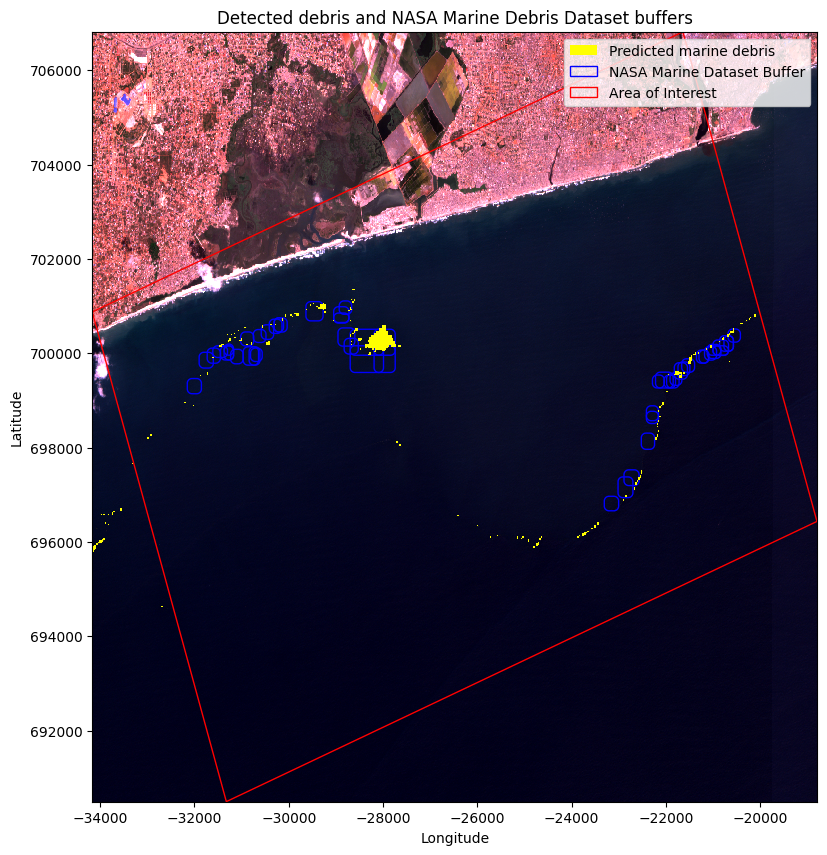

In [19]:
# Convert geopolygon_gdf to EPSG 6933
geopolygon_gdf = geopolygon_gdf.to_crs("EPSG:6933")

# Plot the marine dataset buffers, debris, geopolygon, and clipped coastline
fig, ax = plt.subplots(figsize=(15, 10))

# Create buffers around the marine debris points
buffer_distance = 100  # Specify the buffer distance in the CRS units (meters)
marine_debris_dataset['buffer'] = marine_debris_dataset.geometry.buffer(
    buffer_distance)

# Plot the rgb image
rgb(ds.isel(time=0), ax=ax)
# Plot the marine dataset buffers
buffer_gdf = gpd.GeoDataFrame(geometry=marine_debris_dataset['buffer'])
buffer_gdf.plot(ax=ax, facecolor='none', edgecolor='blue')

# Plot the debris
debris_gdf.plot(ax=ax, facecolor='yellow')

# Plot the geopolygon
geopolygon_gdf.plot(ax=ax, facecolor='none', edgecolor='red')

# Set plot title and labels
ax.set_title('Detected debris and NASA Marine Debris Dataset buffers')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Create custom legend handles and labels
legend_handles = [
    mpatches.Patch(facecolor='yellow', label='Predicted marine debris'),
    mpatches.Patch(facecolor='none',
                   edgecolor='blue',
                   label='NASA Marine Dataset Buffer'),
    mpatches.Patch(facecolor='none', edgecolor='red', label='Area of Interest'),
]

# Add legend
ax.legend(handles=legend_handles)
plt.show()

In this accuracy assessment, we sought to evaluate the performance of marine debris detection in satellite imagery by comparing it with the marine dataset buffers representing potential marine debris areas. To ensure accuracy, we assigned unique identifiers to each buffer and marine debris polygon. By conducting a spatial join operation, we identified the areas of overlap between the buffers and detected marine debris. The goal was to determine how many of the marine dataset buffers contained marine debris. Through this approach, we avoided overcounting buffers with multiple marine debris, as each buffer was counted only once, regardless of the number of intersecting marine debris.

**Disclaimer:**
It is important to note that the accuracy assessment results are dependent on the size of the buffer defined. In this case, the buffer size was selected arbitrarily and not based on specific criteria or scientific guidelines. Therefore, the accuracy percentage obtained should be interpreted within the context of the chosen buffer size. Different buffer sizes may yield different accuracy outcomes.

In [20]:
# Assign a unique identifier to each marine dataset buffer
buffer_gdf['buffer_id'] = range(len(buffer_gdf))

# Assign a unique identifier to each debris polygon
debris_gdf['debris_id'] = range(len(debris_gdf))

# Spatial join between the marine dataset buffers and the debris
intersection = gpd.overlay(buffer_gdf, debris_gdf, how='intersection')

# Count the number of unique buffer IDs with intersecting debris
num_buffers_with_debris = len(intersection['buffer_id'].unique())

# Calculate the total number of marine dataset buffers
num_buffers = len(buffer_gdf)

# Calculate the accuracy
accuracy = (num_buffers_with_debris / num_buffers) * 100

# Print the accuracy assessment
print("Accuracy Assessment:")
print(f"Number of marine dataset buffers: {num_buffers}")
print(
    f"Number of marine dataset buffers with debris: {num_buffers_with_debris}"
)
print(f"Accuracy: {accuracy:.2f}%")

Accuracy Assessment:
Number of marine dataset buffers: 51
Number of marine dataset buffers with debris: 36
Accuracy: 70.59%


The accuracy assessment of marine debris identification within a 100m buffer zone of marine dataset buffers revealed promising results. Although the buffers and the detected marine debris did not overlap perfectly due to movement and natural variations, visual examination indicated a discernible pattern of marine debris presence that aligned with our method of identification. While the accuracy rate of 70.59% indicates that our approach captured a significant portion of the actual marine debris within the buffers, it is important to consider the visual evidence that supports the effectiveness of our method. The offset observed between the detected marine debris and the buffers is expected due to the dynamic nature of marine debris dispersion in marine environments. Overall, the visual observations strengthen our confidence in the accuracy assessment, highlighting the ability of our method to identify marine debris even when perfect spatial alignment is not achieved.

   
##### References:
1. Biermann, L., Clewley, D., Martinez-Vicente, V., Topouzelis, K., 2020. Finding Plastic Patches in Coastal Waters using Optical Satellite Data. Sci. Rep. 10, 1–10. https://doi.org/10.1038/s41598-020-62298-z
2. Themistocleous, K., Papoutsa, C., Michaelides, S., Hadjimitsis, D., 2020. Investigating detection of floating plastic litter from space using sentinel-2 imagery. Remote Sens. 12. https://doi.org/10.3390/RS12162648
3. Topouzelis, K., Papageorgiou, D., Karagaitanakis, A., Papakonstantinou, A., Ballesteros, M.A., 2020. Remote sensing of sea surface artificial floating plastic targets with Sentinel2 and unmanned aerial systems (plastic litter project 2019). Remote Sens. 12. https://doi.org/10.3390/rs12122013
4. Topouzelis, K., Papakonstantinou, A., Garaba, S.P., 2019. Detection of floating plastics from satellite and unmanned aerial systems (Plastic Litter Project 2018). Int. J. Appl. Earth Obs. Geoinf. 79, 175–183. https://doi.org/10.1016/j.jag.2019.03.011

In [21]:
Markdown(os.path.expanduser("~/Supplementary_data/Endnote/Endnote.md"))

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [DE Africa Slack channel](https://digitalearthafrica.slack.com/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**


In [22]:
from datetime import datetime

datetime.today().strftime('%Y-%m-%d')

'2024-11-04'